### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score

### Seed Configuration

In [2]:
# for loading bars on notebook
from tqdm import tqdm

# Set random seed
SEED = 385433  # my G number
np.random.seed(SEED)


### Read in Dataset

In [3]:

# Define dataset path
DATASET_PATH = "fashion"
# CATEGORIES = ['ankleboot', 'bag']
CATEGORIES = ['ankleboot', 'bag', 'coat', 'dress', 'pullover', 'sandal', 'shirt', 'sneaker', 'trouser', 'tshirt-top']

# Load images and labels with progress bar
X, y = [], []
for label, category in enumerate(CATEGORIES):
    folder_path = os.path.join(DATASET_PATH, category)
    files = os.listdir(folder_path)
    for file in tqdm(files, desc=f"Loading {category}"):
        img_path = os.path.join(folder_path, file)
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        img_resized = img.resize((28, 28))  # Resize to 28x28
        X.append(np.array(img_resized).flatten())  # Flatten images
        y.append(label)

X = np.array(X)
y = np.array(y)

print('Read in dataset')

Loading tshirt-top: 100%|████████████████████████████████████████████████████████| 7000/7000 [00:02<00:00, 3334.04it/s]

Read in dataset


### Split Dataset into Train, Validation, and Test Sets

In [4]:
# Split into training, validation, and test sets with progress bar
print("Splitting dataset...")
with tqdm(total=2, desc="Splitting Data") as pbar:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, shuffle=True, stratify=y)
    pbar.update(1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED, shuffle=True, stratify=y_train)
    pbar.update(1)

# Check dataset distribution
print("Training Set Shape:", X_train.shape, y_train.shape)
print("Validation Set Shape:", X_val.shape, y_val.shape)
print("Test Set Shape:", X_test.shape, y_test.shape)
print("Class Distribution in Training Set:")
print(pd.Series(y_train).value_counts(normalize=True))


Splitting dataset...


Splitting Data: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 24.27it/s]

Training Set Shape: (44800, 784) (44800,)
Validation Set Shape: (11200, 784) (11200,)
Test Set Shape: (14000, 784) (14000,)
Class Distribution in Training Set:
9    0.1
6    0.1
8    0.1
2    0.1
1    0.1
7    0.1
3    0.1
4    0.1
5    0.1
0    0.1
Name: proportion, dtype: float64


### Define Models to Train

In [5]:
# Define models to train
models = {
    "SVM": SVC(kernel='rbf', random_state=SEED),
    "kNN": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=SEED)#,
#     "Random Forest": RandomForestClassifier(n_estimators=100, random_state=SEED)
}

# Train Models and Evaluate Performance

In [6]:
models.items()

dict_items([('SVM', SVC(random_state=385433)), ('kNN', KNeighborsClassifier()), ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=385433))])

In [7]:
import datetime, time
print(datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

print("Checking model training times...")
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train[:500], y_train[:500])  # Train on small subset
    end_time = time.time()
    print(f"{name} took {end_time - start_time:.2f} seconds on a small subset.")
# Train models and evaluate performance
results = {}
cross_val_results = {}

print("Training Models...")

with tqdm(total=len(models), desc="Training Progress", leave=True) as pbar:
    for name, model in models.items():
        print(f"\nTraining {name}...")

        start_time = time.time()  # Track time

        # Train the model with a progress indicator
        for i in tqdm(range(1), desc=f"Fitting {name}", leave=False):
            model.fit(X_train, y_train)

        end_time = time.time()
        print(f"{name} training took {end_time - start_time:.2f} seconds.")

        # Make predictions
        y_pred = model.predict(X_val)

        # Cross-validation with progress bar
        cross_val_scores = []
        for score in tqdm(cross_val_score(model, X_train, y_train, cv=3), desc=f"Cross-validation {name}", leave=False):
            print(score)
            cross_val_scores.append(score)

        cross_val_score_avg = np.mean(cross_val_scores)

        results[name] = accuracy_score(y_val, y_pred)
        cross_val_results[name] = cross_val_score_avg

        print(f"{name} Classification Report:\n", classification_report(y_val, y_pred))
        pbar.update(1)  # Update the outer progress bar

print("\nModel training complete!")
print(datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

2025-03-21 17:22:14
Checking model training times...
SVM took 0.08 seconds on a small subset.
kNN took 0.00 seconds on a small subset.
Logistic Regression took 1.01 seconds on a small subset.
Training Models...


Training Progress:   0%|                                                                         | 0/3 [00:00<?, ?it/s]


Training SVM...



Fitting SVM: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [03:38<00:00, 218.89s/it]
                                                                                                                       

SVM training took 218.90 seconds.



Training Progress:  33%|█████████████████████▎                                          | 1/3 [16:28<32:57, 988.70s/it]

0.8825498861657962
0.8810018080760731
0.8771177928078752
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96      1120
           1       0.96      0.98      0.97      1120
           2       0.81      0.83      0.82      1120
           3       0.88      0.91      0.90      1120
           4       0.81      0.82      0.82      1120
           5       0.97      0.95      0.96      1120
           6       0.74      0.65      0.69      1120
           7       0.93      0.95      0.94      1120
           8       1.00      0.96      0.98      1120
           9       0.82      0.88      0.85      1120

    accuracy                           0.89     11200
   macro avg       0.89      0.89      0.89     11200
weighted avg       0.89      0.89      0.89     11200


Training kNN...



Fitting kNN:   0%|                                                                               | 0/1 [00:00<?, ?it/s]
                                                                                                                       

kNN training took 0.01 seconds.



Training Progress:  67%|██████████████████████████████████████████▋                     | 2/3 [17:23<07:19, 439.33s/it]

0.8492701218695594
0.8428982789794415
0.8424295185160383
kNN Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92      1120
           1       0.97      0.96      0.97      1120
           2       0.74      0.78      0.76      1120
           3       0.91      0.86      0.88      1120
           4       0.74      0.79      0.76      1120
           5       1.00      0.81      0.89      1120
           6       0.67      0.58      0.62      1120
           7       0.88      0.95      0.91      1120
           8       0.99      0.97      0.98      1120
           9       0.79      0.86      0.83      1120

    accuracy                           0.85     11200
   macro avg       0.86      0.85      0.85     11200
weighted avg       0.86      0.85      0.85     11200


Training Logistic Regression...



Fitting Logistic Regression:   0%|                                                               | 0/1 [00:00<?, ?it/s]C:\Users\caola\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(

Fitting Logistic Regression: 100%|███████████████████████████████████████████████████████| 1/1 [01:22<00:00, 82.93s/it]
                                                                                                                       

Logistic Regression training took 82.94 seconds.


C:\Users\caola\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\caola\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

0.8317932235168073
0.8276970468090805
0.8213352976628943
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.92      1120
           1       0.92      0.93      0.92      1120
           2       0.73      0.76      0.75      1120
           3       0.86      0.85      0.85      1120
           4       0.74      0.76      0.75      1120
           5       0.93      0.90      0.92      1120
           6       0.65      0.57      0.61      1120
           7       0.91      0.91      0.91      1120
           8       0.94      0.97      0.95      1120
           9       0.79      0.82      0.80      1120

    accuracy                           0.84     11200
   macro avg       0.84      0.84      0.84     11200
weighted avg       0.84      0.84      0.84     11200


Model training complete!


### Compare Model Performance (Accuracy and Cross-Validation)


Model Performance:
                     Accuracy
SVM                  0.888393
kNN                  0.853482
Logistic Regression  0.838750

Cross-Validation Performance:
                     Cross-Val Accuracy
SVM                            0.880223
kNN                            0.844866
Logistic Regression            0.826942


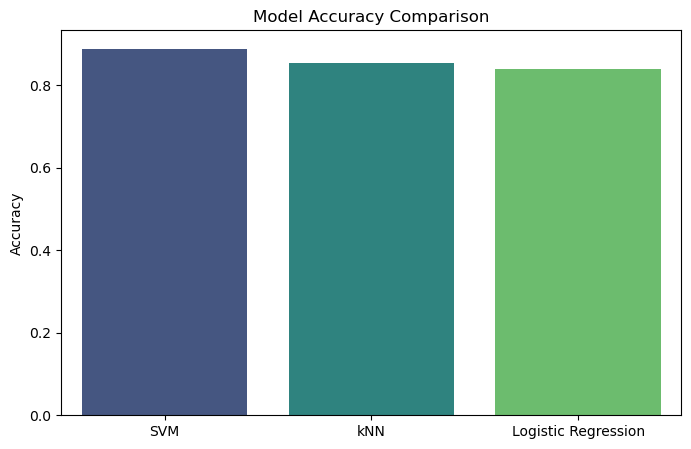

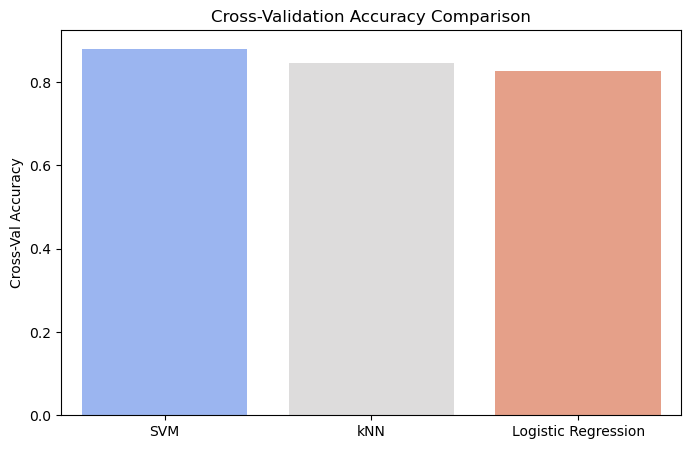

In [10]:
# Compare Results
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy'])
cross_val_df = pd.DataFrame.from_dict(cross_val_results, orient='index', columns=['Cross-Val Accuracy'])
print("\nModel Performance:")
print(results_df)
print("\nCross-Validation Performance:")
print(cross_val_df)

# Plot model accuracy comparison
plt.figure(figsize=(8, 5))
sns.barplot(x=results_df.index, y=results_df["Accuracy"], palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

# Plot cross-validation accuracy comparison
plt.figure(figsize=(8, 5))
sns.barplot(x=cross_val_df.index, y=cross_val_df["Cross-Val Accuracy"], palette="coolwarm")
plt.title("Cross-Validation Accuracy Comparison")
plt.ylabel("Cross-Val Accuracy")
plt.show()


# Evaluate the Best Model on Test Set

In [11]:
# Evaluate Best Model on Test Set
best_model_name = results_df["Accuracy"].idxmax()
best_model = models[best_model_name]
y_test_pred = best_model.predict(X_test)

print(f"\nBest Model: {best_model_name}")
print("Test Set Classification Report:")
print(classification_report(y_test, y_test_pred))



Best Model: SVM
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1400
           1       0.96      0.97      0.97      1400
           2       0.81      0.84      0.82      1400
           3       0.88      0.92      0.89      1400
           4       0.81      0.82      0.82      1400
           5       0.96      0.96      0.96      1400
           6       0.74      0.67      0.70      1400
           7       0.94      0.95      0.94      1400
           8       1.00      0.97      0.98      1400
           9       0.83      0.85      0.84      1400

    accuracy                           0.89     14000
   macro avg       0.89      0.89      0.89     14000
weighted avg       0.89      0.89      0.89     14000

